/usr/local/lib/python3.6/site-packages/pandas/compat/__init__.py:117: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there are two
    options available in V2.
    - tf.py_function takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    - tf.numpy_function maintains the semantics of the deprecated tf.py_func
    (it is not differen

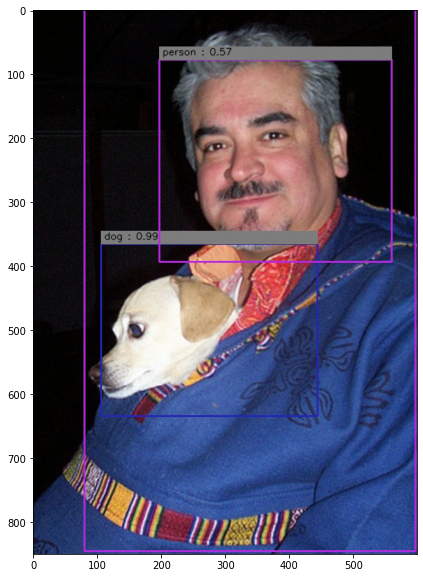

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import config as cfg
import os
import pascal_voc as pascl
import numpy as np
import tensorflow as tf
import network
import datetime
import cv2
from nms import py_cpu_nms
import matplotlib.pyplot as plt
from PIL import Image


class Val_test(object):   
    def __init__(self, net ,val_data):
        self.net = net
        self.val_data = val_data
        self.overlaps_max = cfg.overlaps_max
        self.overlaps_min = cfg.overlaps_min
        self.ckpt_filename = tf.train.latest_checkpoint(cfg.OUTPUT_DIR)
        self.test_output_dir = cfg.test_output_path
        self.image_output_dir = cfg.image_output_dir



    def test_model(self):
        saver = tf.train.Saver()
        _rois_coord = self.net.rois_coord[:,1:5]
        #rois_coord = self.net.rois_coord
        _pred_box = self.net.bbox_pred
        _pred_score = self.net.cls_prob
        _pred_box_score_arg = tf.argmax(_pred_score, axis=1)
        dect_total_result = [[[] for i in range(cfg.img_save_num)] for j in range(self.net.num_classes)]
        test_data = [[] for i in range (cfg.img_save_num)]
        with tf.Session() as sess:
            saver.restore(sess, self.ckpt_filename)
            for i in range (cfg.img_save_num):
                print (i, ' image test compeleted')            
                train_data = self.val_data.get()  #if you want to change the test imgae, you can using cv2.imread() here to read your own image data
                test_data[i] = train_data
                image_height = np.array(train_data['image'].shape[1])
                image_width = np.array(train_data['image'].shape[2])
#                 feed_dict = {self.net.image: train_data['image'], self.net.image_width: image_width,\
#                              self.net.image_height: image_height}
                
                saver.save(sess, './checkpoint_zky/MyModel')
                feed_dict = {"Placeholder:0": train_data['image'], "Placeholder_1:0": image_width,\
                             "Placeholder_2:0": image_height}
#                 print('我需要的tensor',self.net.image, self.net.image_width, self.net.image_height)               

#                 print('我需要的tensor',_rois_coord, _pred_box, _pred_box_score_arg, _pred_score)               
#                 rois_coord, pred_box, pred_box_score_arg, pred_score= sess.run([_rois_coord, _pred_box, _pred_box_score_arg, _pred_score],\
#                                                                         feed_dict=feed_dict)
                
                rois_coord, pred_box, pred_box_score_arg, pred_score= sess.run(["strided_slice_13:0", "vgg_16_2/region_deciton/bbox_pred/BiasAdd:0",
                                                                                "ArgMax:0", "vgg_16_2/region_deciton/cls_prob:0"],\
                                                                        feed_dict=feed_dict)
                
                
                #我需要的tensor Tensor("Placeholder:0", shape=(1, ?, ?, 3), dtype=float32) Tensor("Placeholder_1:0", dtype=int64) 
                #Tensor("Placeholder_2:0", dtype=int64)
                print(rois_coord, pred_box, pred_box_score_arg, pred_score)
                
                #  我需要的tensor Tensor("strided_slice_13:0", shape=(?, ?), dtype=float32) 
                #Tensor("vgg_16_2/region_deciton/bbox_pred/BiasAdd:0", shape=(?, 84), dtype=float32) 
                #Tensor("ArgMax:0", shape=(?,), dtype=int64) Tensor("vgg_16_2/region_deciton/cls_prob:0", shape=(?, 21), dtype=float32)
                pred_box_score_arg = pred_box_score_arg.astype(np.int32)
                num_pred = pred_box_score_arg.shape[0]
                pred_box_gather = np.empty([num_pred, 4], dtype = np.float32)
                pred_score_gather = np.empty(num_pred)
                
                for j in range(num_pred):
                    pred_box_gather[j, :] = pred_box[j, 4*pred_box_score_arg[j]:4*(pred_box_score_arg[j]+1)]
                    pred_score_gather[j] = pred_score[j, pred_box_score_arg[j]]
                    
                pred_box_gather = pred_box_gather * np.array(cfg.bbox_nor_stdv) + np.array(cfg.bbox_nor_mean)
                pre_box_coord = self.coord_transform_inv(rois_coord, pred_box_gather.astype(np.float32))
                pre_box_coord = pre_box_coord
                for k in range(1, self.net.num_classes):
                    pre_class_arg = np.where(pred_box_score_arg==k)[0]
                    cls_pred_box_coord = pre_box_coord[pre_class_arg, :]
                    cls_pred_score = pred_score_gather[pre_class_arg]
                    #print(cls_pred_box_coord.shape, cls_pred_score.shape)
                    cls_pred_score = cls_pred_score[:, np.newaxis]  
                    cls_pred_target = np.concatenate((cls_pred_box_coord, cls_pred_score), axis=1)
                    keep = py_cpu_nms(cls_pred_target, cfg.test_nms_thresh)
                    cls_pred_target = cls_pred_target[keep, :]
                    dect_total_result[k][i] = cls_pred_target

            for k in range(cfg.img_save_num):
                imname = test_data[k]['imname']
                im_scale = test_data[k]['scale']
                image = cv2.imread(imname)
                im = cv2.resize(image, None, None, fx=im_scale, fy=im_scale, interpolation=cv2.INTER_LINEAR)
                im = self.draw_result(im, dect_total_result, k)
                if not os.path.exists(self.image_output_dir):
                    os.mkdir(self.image_output_dir)
                im_save_path = os.path.join(self.image_output_dir, '{:d}'.format(k)+'.jpg')
                cv2.imwrite(im_save_path, im)
                
                
#                 cv2.imshow('Image',im)#这里有环境问题
#                 cv2.destroyAllWindows()
                plt.figure(figsize=(10,10))
        
                im = Image.open(im_save_path)
                plt.imshow(im)  #显示需要识别的图片
                plt.show()
                
                
                
                
                cv2.waitKey(0)


    def draw_result(self, img, result, ind):
        for i in range(1, self.net.num_classes):
            for j in range(result[i][ind].shape[0]):
                if result[i][ind][j][4]>0.5:
                    x1 = int(result[i][ind][j][0])
                    y1 = int(result[i][ind][j][1])
                    x2 = int(result[i][ind][j][2])
                    y2 = int(result[i][ind][j][3])                    
                    cv2.rectangle(img, (x1, y1), (x2, y2), ((i%19)*15, (i%3)*100+40, (i%6)*50+35), 2) 
                    cv2.rectangle(img, (x1, y1-20),(x2, y1), (125, 125, 125), -1)
                    lineType = cv2.LINE_AA if cv2.__version__ > '3' else cv2.CV_AA
                    cv2.putText(img, cfg.CLASSES[i] + ' : %.2f' % result[i][ind][j][4],\
                    (x1 + 5, y1 - 7), cv2.FONT_HERSHEY_SIMPLEX, 0.5,\
                    (0, 0, 0), 1, lineType)                
        return img
        
        
    def coord_transform_inv (self, anchors, boxes):
        anchors = anchors.astype(np.float32)
        anchors = np.reshape(anchors, [-1,4])
        anchor_x = (anchors[:,2] + anchors[:,0]) * 0.5
        anchor_y = (anchors[:,3] + anchors[:,1]) * 0.5
        acnhor_w = (anchors[:,2] - anchors[:,0]) + 1.0
        acnhor_h = (anchors[:,3] - anchors[:,1]) + 1.0
        boxes = np.reshape(boxes, [-1,4])
        boxes_x = boxes[:,0]*acnhor_w + anchor_x
        boxes_y = boxes[:,1]*acnhor_h + anchor_y
        boxes_w = np.exp(boxes[:,2])*acnhor_w
        boxes_h = np.exp(boxes[:,3])*acnhor_h
        coord_x1 = boxes_x - boxes_w*0.5
        coord_y1 = boxes_y - boxes_h*0.5
        coord_x2 = boxes_x + boxes_w*0.5
        coord_y2 = boxes_y + boxes_h*0.5
        coord_result = np.stack([coord_x1, coord_y1, coord_x2, coord_y2], axis=1)
        return coord_result                  
    
    
#get variables_to_restore               
    def get_var_list(self, global_variables, ckpt_variables):
        variables_to_restore = []
        for key in global_variables:
            if key.name.split(':')[0] in ckpt_variables:
                variables_to_restore.append(key) 
        return variables_to_restore
    
    

if __name__ == '__main__':
    os.environ['CUDA_VISIBLE_DEVICES'] = cfg.GPU_ID
#     import os
#     os.environ['TF_CPP_MIN_LOG_LEVEL'] = '0'
    net = network.Net(is_training=False)
    val_data = pascl.pascal_voc(cfg.test_imdb_name, 'test', fliped=False)
    test = Val_test(net, val_data)
    print ('start training')
    test.test_model()
